# Predicting competitor's promotion strategies using ensemble methods

The aim of the project is to predict whether a competitor's price change is a regular price change or a promotion. This is done by using classification methods with ensemble methods. Once we determine whether the price change is a promotion or not, we will use boosting methods to predict what promotion the competitor is likely to give. This will allow us to anticipate future promotions of the competitor and to adjust the pricing strategies accordingly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Set the desired inputs
store_id = '1501'

categories = ["rice", "pasta","legumes and cereals","biscuits", "waffles", "chocolates", "black coffee", "toilet paper", "yogurt","cheese","canned food","wine","beer","water","non alcoholic carbonated beverages","non alcoholic non carbonated beverages","toothpaste","bread", "flour and semolina","gums and candies","honey and date honey", "jam and confiture", "ketchup, mayonnaise and mustard", "pastrami, sausage and kabanos", "pickled or smoked fish","deodorant","shower gel","shampoo"]

In [3]:
# Import the calender
start_date = "2018-12-31"
calendar = pd.read_excel("C:/Users/Documents/calendar.xlsx")
calendar['Date'] = pd.to_datetime(calendar['Date'])
calendar = calendar[calendar['Date']>start_date]

# Import promotion category data
promotion_category = pd.read_excel('promotion_id.xlsx')

promotion_data = pd.read_excel('promotion_variaty_id_2.xlsx', sheet_name='product_promotion')
promotion_data = promotion_data[promotion_data['category'].isin(categories)]
promotion_data['PromotionDescription'] = promotion_data['PromotionDescription'].astype('str')
promotion_data = pd.merge(promotion_data, promotion_category, on="PromotionID")
promotion_data.columns = ['DiscountDescription','PromotionID','category','PromotionType']
promotion_data.drop_duplicates(subset='DiscountDescription', inplace=True)

# Import the store price changes data
store_data = []
for category in categories:
    df_cat = readRDS('G:/retail data/price change data/'+category+'/'+store_id+'.rds')
    df_cat = pandas2ri.rpy2py_dataframe(df_cat)
    
    # filter the data
    df_cat['Date'] = pd.to_datetime(df_cat['Date'], utc=True, unit='d').apply(lambda x: x.strftime('%Y-%m-%d'))
    df_cat['Date'] = pd.to_datetime(df_cat['Date'], errors='coerce')
    df_cat['Date_Tminus1'] = pd.to_datetime(df_cat['Date_Tminus1'], utc=True, unit='d').apply(lambda x: x.strftime('%Y-%m-%d'))
    df_cat['Date_Tminus1'] = pd.to_datetime(df_cat['Date_Tminus1'], errors='coerce')
    df_cat = df_cat[df_cat['Date'].dt.strftime('%Y-%m-%d') >= '2019-01-01']
    df_cat['DiscountDescription'] = df_cat['DiscountDescription'].str.replace('\n', '')
    df_cat['DiscountDescription_Tminus1'] = df_cat['DiscountDescription_Tminus1'].str.replace('\n', '')
    
    df_cat['category'] = category
    
    store_data.append(df_cat)

store_data = pd.concat(store_data)
store_data= store_data.reset_index(drop=True)
store_data = pd.merge(store_data, promotion_data, how='left', on="DiscountDescription")
store_data = pd.merge(store_data, calendar, how='left', on="Date")
store_data[:5]

,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName,...,WeekNumber,MonthDay,Month,MonthName,Year,HebrewMonthDay,HebrewMonth,HebrewYear,Event,Description
0,7290100700389,אורז אדום סוגת 1 קילו,סוגת,אורז,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,...,1,3,1,January,2019,26,Tevet,5779,NaN,NaN
1,7290100700389,אורז אדום סוגת 1 קילו,סוגת,אורז,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,...,10,9,3,March,2019,2,Adar II,5779,NaN,NaN
2,7290100700389,אורז אדום סוגת 1 קילו,סוגת,אורז,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,...,26,25,6,June,2019,22,Sivan,5779,NaN,NaN
3,7290100700389,אורז אדום סוגת 1 קילו,סוגת,אורז,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,...,35,27,8,August,2019,26,Av,5779,NaN,NaN
4,5011157630281,אורז בסמטי טילדה 1 קילו,טילדה,אורז,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,...,12,15,3,March,2020,19,Adar,5780,NaN,NaN


### Feature engineering

In [4]:
store_data['PriceDecrease'] = ((store_data['FinalPrice'] - store_data['FinalPrice_Tminus1'])<0).astype(int)
store_data['PromotionDecrease'] = ((store_data['PriceDecrease'] == 1) & (store_data['PromotionType'].notnull())).astype(int)

### EDA

##### Histogram of prices and boxplot of price distribution by product category

The histogram can help identify the range of prices, the most common price range, and whether there are any outliers.

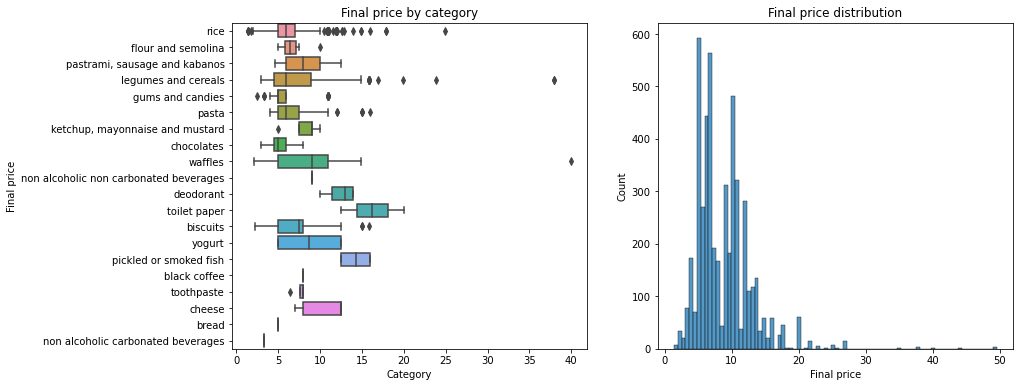

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Boxplot of prices by category
sns.boxplot(y='category_y', x='FinalPrice', data=store_data, ax=axs[0])
axs[0].set_title('Final price by category')
axs[0].set_xlabel('Category')
axs[0].set_ylabel('Final price')

# Histogram of prices
sns.histplot(x='FinalPrice', data=store_data, ax=axs[1])
axs[1].set_title('Final price distribution')
axs[1].set_xlabel('Final price')

plt.show()

##### Promotion type distribution

The bar chart of the promotion types gives an understanding of how frequently different types of promotions occur in the dataset.

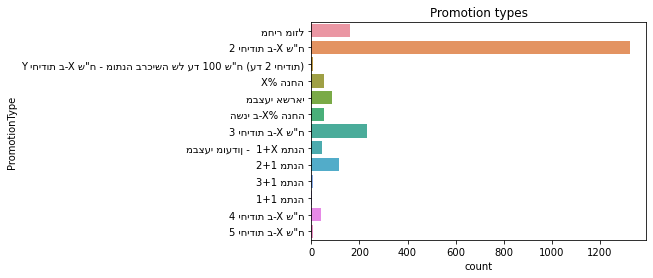

In [6]:
sns.countplot(y='PromotionType', data=store_data)
plt.title('Promotion types')
plt.show()

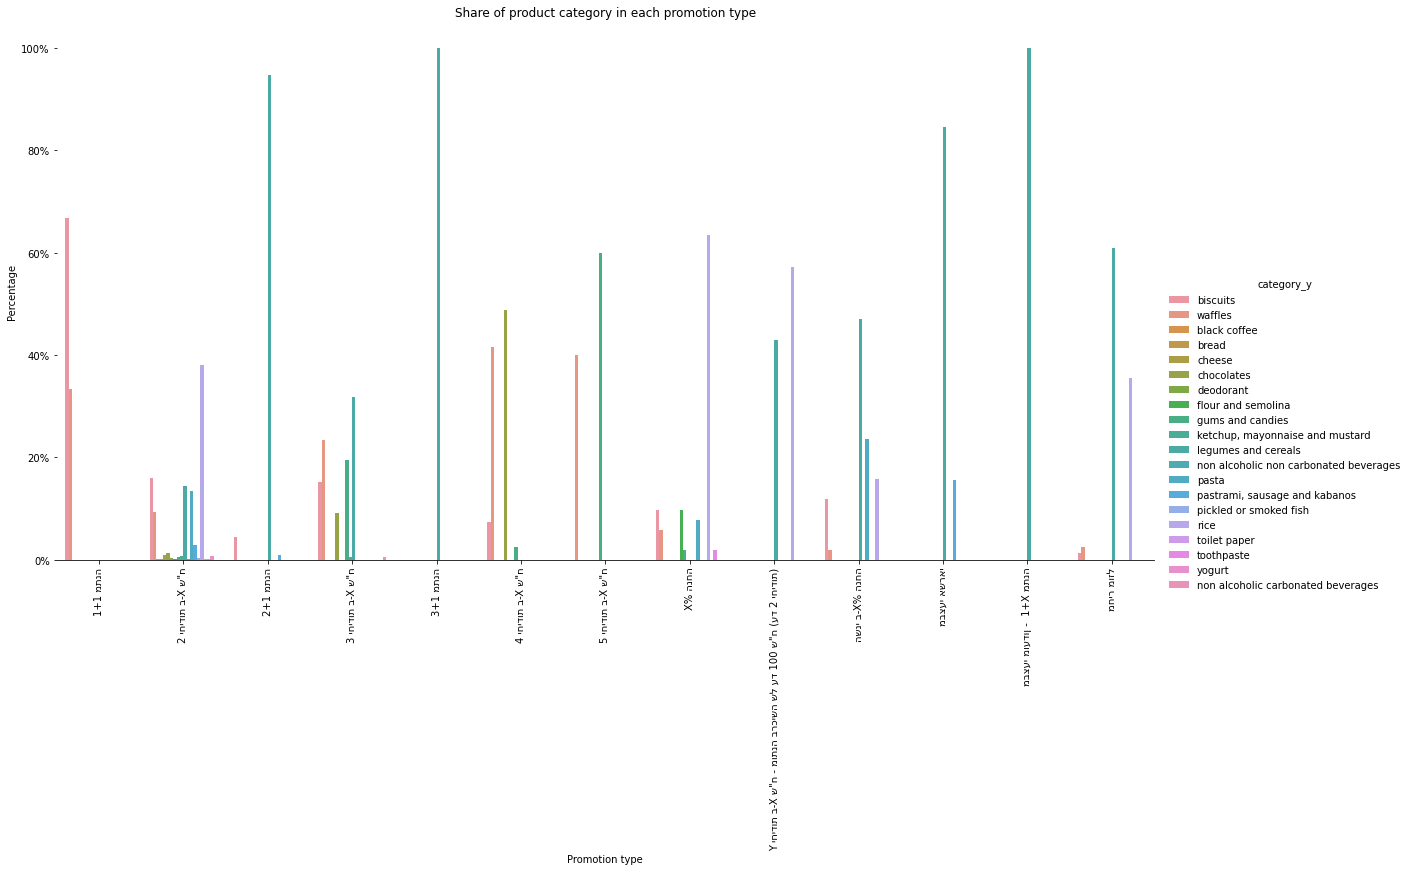

In [7]:
# Calculate the share of each category in each promotion type
grouped = store_data.groupby(['PromotionType', 'category_y']).size().reset_index(name='count')
totals = grouped.groupby('PromotionType')['count'].transform('sum')
grouped['share'] = grouped['count'] / totals

# Plot the stacked bar chart
g = sns.catplot(x='PromotionType', y='share', hue='category_y', data=grouped, kind='bar', height=8, aspect=2)
g.set_axis_labels('Promotion type', 'Percentage')
g.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
g.despine(left=True)
plt.xticks(rotation=90)
plt.title('Share of product category in each promotion type')
plt.show()

## Prediction of promotion-related price drops

The first phase of the project aims to predict whether a price drop is related to a promotion or not. We will use for that various ensemble methods such as bagging, boosting, stacking, voting, and more. This will allow to supermarkets gain a better understanding of their competitors' pricing strategies.

##### Data preparation

In [8]:
price_reduction_df = store_data[store_data['PriceDecrease']==1]
price_reduction_df = price_reduction_df[['PromotionDecrease','ProductDescription','Category','FinalPrice_Tminus1','Price_Tminus1','Hour','WeekDay','MonthDay','HebrewMonthDay','HebrewMonth']]
price_reduction_df = pd.get_dummies(price_reduction_df, columns=['ProductDescription','Category','Hour','WeekDay','MonthDay','HebrewMonthDay','HebrewMonth'], drop_first=True)
print(price_reduction_df['PromotionDecrease'].value_counts())
price_reduction_df[:5]

1    1901
0     678
Name: PromotionDecrease, dtype: int64


,PromotionDecrease,FinalPrice_Tminus1,Price_Tminus1,ProductDescription_אורז בסמטי הודי בצנצנת שופרסל 1 קילו,ProductDescription_אורז בסמטי הודי בשקית עם סגירה חוזרת שופרסל 1 קילו,ProductDescription_אורז בסמטי חום אורגני גרין 1 קילו,ProductDescription_אורז בסמטי חום מלא מהיר הכנה דאוואט 1 קילו,ProductDescription_אורז בסמטי טילדה 1 קילו,ProductDescription_אורז בסמטי מובחר וילי פוד 1 קילו,ProductDescription_אורז בסמטי מלא אורגני גרין 1 קילו,...,HebrewMonth_Cheshvan,HebrewMonth_Elul,HebrewMonth_Iyyar,HebrewMonth_Kislev,HebrewMonth_Nisan,HebrewMonth_Sh'vat,HebrewMonth_Sivan,HebrewMonth_Tamuz,HebrewMonth_Tevet,HebrewMonth_Tishrei
0,1,10.9,12.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,12.8,12.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,24.9,24.9,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,24.9,24.9,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
8,0,24.9,24.9,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
# Train - test split

# Define the features and target variable
X = price_reduction_df.drop(columns=['PromotionDecrease'])
y = price_reduction_df['PromotionDecrease']

# Split the data into training and testing sets with a 70:30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Oversample the minority class using RandomOverSampler
oversampler = RandomOverSampler(random_state=42, sampling_strategy=0.8)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [10]:
# track model performance
log_models = pd.DataFrame(columns=['model','cv_score', 'test_score'])

### Ensemble methods

#### Bagging

In bagging, multiple base models are trained on different subsets of the original data, and then the predictions of these models are combined to create a final prediction. Thus, it can help reduce the variance in the predictions of the individual models. Bagging is a good choice when the base models are unstable or overfitting, and when the goal is to reduce the variance in the predictions of the individual models like decision trees. Here, we decide to use decision trees as base estimators.

##### Random forest

Random forests also use decision trees as base estimators, but they add an additional layer of randomness. Specifically, each tree is trained on a bootstrap sample of the original data, as in bagging, but at each split in the tree, only a subset of the features are considered for splitting. This introduces correlation between the trees and helps to reduce the variance of the ensemble.

#### Boosting

In boosting, a series of weak models are combined to create a strong model. In each iteration, the algorithm focuses on the instances that were misclassified in the previous iterations, and creates a new model that correctly classifies these instances. Boosting can be particularly useful when dealing with imbalanced datasets by giving more weight to the underrepresented class and improve the performance on the minority class. We will use two popular algorithms in the boosting family, AdaBoost and Gradient Boosting, both of which we will use decision trees as their base model.

The main difference between AdaBoost and gradient boosting is their approach to focusing on difficult examples. While AdaBoost focuses on the misclassified examples, gradient boosting focuses on the residuals of the previous model. AdaBoost builds a weighted combination of multiple weak models, whereas gradient boosting builds one strong model by sequentially optimizing a loss function.

##### AdaBoost

AdaBoost is a type of boosting that focuses on instances that are hard to classify. It does this by assigning weights to each training example based on their classification accuracy, and then boosting the weight of the misclassified examples for the next iteration. In each iteration, AdaBoost builds a weak model that focuses on the most difficult examples to classify. The final model is then a weighted sum of these weak models.

##### Gradient boosting

Gradient boosting, on the other hand, builds the models sequentially in a way that minimizes the loss function of the overall model. Each new model in the sequence is trained on the residuals of the previous model. It tries to minimize the gradient of the loss function with respect to the predicted values of the model. 


#### Stacking

In stacking, the predictions of multiple base models are combined as input to a higher-level model, called the meta-model. Unlike bagging and boosting, which mainly focus on improving the performance of a single type of model, stacking allows us to leverage the strengths of multiple models that may have different characteristics and modeling approaches.

#### Voting

In voting, the predictions from multiple individual models are combined by taking the majority vote of their predictions. It is particularly useful when the base models have different strengths and weaknesses and can provide complementary information. It can also be a good choice when the data is not too large, and the base models are relatively simple and computationally efficient.

### Base models

##### Decision trees (DTs)

Since decision trees tend to have low bias and high variance, bagging can be particularly effective at reducing variance in decision tree models. Also, they are often used as the base estimator for other ensemble algorithms because they can capture complex nonlinear relationships in the data and can be tuned to handle imbalanced data.

##### K-neighbors classifier

It is particularly useful when the decision boundary is irregular or when there are regions of high and low density in the feature space, thus, it can capture the local structure of the data.

##### SVM

SVM is particularly useful when the data is high-dimensional or when there are nonlinear relationships between features and the target variable, thus, it can capture the overall structure of the data.

##### Nearest centroid classifier

The model is a good choice when the data is sparse or when there are clusters or subgroups in the feature space, thus, it can be used to provide a localized and interpretable classification.

##### Logistic regression

Logistic regression is a linear model and it outputs probabilities, rather than hard classifications. This allows it to be easily incorporated into ensemble models that require probability estimates, such as voting classifiers. Additionally, it is a popular choice for the meta-learner in the stacking ensemble method because it is a simple and interpretable model, and is computationally efficient.


 Bagging:
Cross-validation accuracy for Bagging: 0.9191610181868164
Test accuracy for Bagging: 0.8824289405684754

 Random forest:
Cross-validation accuracy for Random forest: 0.9332577339072017
Test accuracy for Random forest: 0.9031007751937985

 AdaBoost:
Cross-validation accuracy for AdaBoost: 0.9224779430083417
Test accuracy for AdaBoost: 0.8630490956072352

 Gradient boosting:
Cross-validation accuracy for Gradient boosting: 0.7715694612681803
Test accuracy for Gradient boosting: 0.7751937984496124

 Stacking - Weak models:
Cross-validation accuracy for Stacking - Weak models: 0.9270405401922632
Test accuracy for Stacking - Weak models: 0.8811369509043928

 Stacking - Ensemble models:
Cross-validation accuracy for Stacking - Ensemble models: 0.9469429482058024
Test accuracy for Stacking - Ensemble models: 0.8940568475452196

 Voting - Weak models:
Cross-validation accuracy for Voting - Weak models: 0.9195733786929889
Test accuracy for Voting - Weak models: 0.900516795865633

 Vo

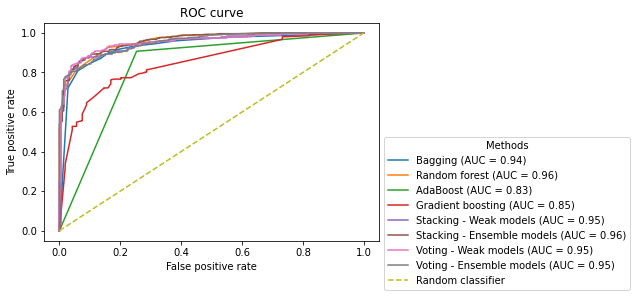

In [11]:
# decision tree as base estimator for bagging and boosting methods
dtc = DecisionTreeClassifier()

# add K-nn and SVM as base estimator for stacking and voting
knn = KNeighborsClassifier()
svm = SVC(probability=True, kernel='linear')
nc = NearestCentroid()
lr = LogisticRegression()

weak_estimators_stacking = [('knn',knn),('decision tree', dtc),('svm',svm),('nc',nc)]
weak_estimators_voting = [('knn',knn),('decision tree', dtc),('svm',svm),('lr',lr)]

# Define the meta-model for stacking
meta_model = LogisticRegression()

# Bagging
bagging = BaggingClassifier(dtc, n_estimators=10, random_state=42)

## Random forest
rfc = RandomForestClassifier(n_estimators=10, random_state=42)

# Boosting
## AdaBoost
adaboost = AdaBoostClassifier(dtc, n_estimators=10, random_state=42)

## Gradient boosting
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)


# define the set of ensemble estimators for stacking and voting
ensemble_estimators = [('bagging',bagging),('adaboost',adaboost),('rfc',rfc),('gbc',gbc)]

# Stacking
## Staking of weak estimators
weak_stacking = StackingClassifier(estimators=weak_estimators_stacking, final_estimator=meta_model)

## Staking of ensemble estimators
ensemble_stacking = StackingClassifier(estimators=ensemble_estimators, final_estimator=meta_model)

# Voting

## Voting of weak estimators
weak_voting = VotingClassifier(estimators=weak_estimators_voting, voting='soft')

## Voting of ensemble estimators
ensemble_voting = VotingClassifier(estimators=ensemble_estimators, voting='soft')


# Fit the model
models = [('Bagging',bagging), ('Random forest',rfc), ('AdaBoost',adaboost), ('Gradient boosting',gbc), ('Stacking - Weak models',weak_stacking), ('Stacking - Ensemble models',ensemble_stacking), ('Voting - Weak models',weak_voting), ('Voting - Ensemble models',ensemble_voting)]

for model_name, model in models:
    print(f'\n {model_name}:')
    # Fit the model on the training data
    model.fit(X_train, y_train)
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = cv_scores.mean()
    print(f"Cross-validation accuracy for {model_name}: {mean_cv_score}")
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    print(f"Test accuracy for {model_name}: {test_score}")
    
    # Record the evaluation scores
    log_models.loc[len(log_models)] = [model_name,mean_cv_score,test_score]
    
    # Plot the ROC curve
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    
# plot the ROC curve for all the models
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(title='Methods', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
log_models = log_models.set_index('model')
log_models = log_models.sort_values(by="test_score",ascending=False)
log_models

,cv_score,test_score
model,,
Random forest,0.933258,0.903101
Voting - Weak models,0.919573,0.900517
Stacking - Ensemble models,0.946943,0.894057
Bagging,0.919161,0.882429
Stacking - Weak models,0.927041,0.881137
Voting - Ensemble models,0.928699,0.874677
AdaBoost,0.922478,0.863049
Gradient boosting,0.771569,0.775194


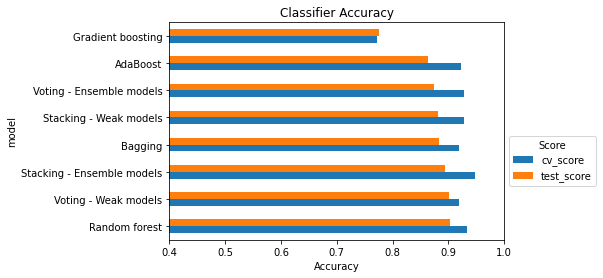

In [13]:
log_models.plot.barh()
plt.title('Classifier Accuracy')
plt.legend(title='Score', bbox_to_anchor=(1, 0.5))
plt.xlabel('Accuracy')
plt.xlim((0.4,1))
plt.show()

The highest cross-validation score of 0.95 was obtained by the Stacking - Ensemble models, followed by the Random forest with a score of 0.93. However, when evaluating the models on the test data, the Random forest performed the best with a test accuracy of 0.903, followed by the Voting - Weak models with a test score of 0.901. On the other hand, Gradient boosting had the lowest cross-validation score of 0.77 and also the worst test accuracy of 0.77.

It is possible that the superior performance of the random forest model can be attributed to its ability that it is an ensemble of decision trees that are trained on random subsets of the data, which helps to reduce overfitting and improve generalization. Also it is possible that the hyperparameters of the random forest model were better optimized compared to other models.

## Prediction of promotion types

The second phase of the project aims to classify the type of promotion that the competitor can offer after determining if a price drop is related to a promotion or not. For this purpose, we will use advanced boosting algorithms like XGBoost and CatBoost, which are known to handle complex tabular data and offer state-of-the-art performance in predictive accuracy. This will enable supermarkets to adjust their own pricing strategies and compete more effectively in the market.

In the first phase of the project, the main goal was to determine if a price drop was related to a promotion or not. This is a binary classification task, and simpler ensemble methods like bagging, boosting, and stacking can perform well in this context. In the second phase of the project, the goal is to predict the specific type of promotion used by the competitor. This is a more complex task that requires more sophisticated models to capture the relationships between the various features of the data.

##### Data preparation

In [14]:
promotion_df = store_data[(store_data['PriceDecrease']==1) & (store_data['PromotionType'].isnull()==False)]
promotion_df = promotion_df[['PromotionType','ProductDescription','category_y','FinalPrice_Tminus1','Price_Tminus1','Hour','WeekDay','MonthDay','HebrewMonthDay','HebrewMonth']]
promotion_df = pd.get_dummies(promotion_df, columns=['ProductDescription','category_y','Hour','WeekDay','MonthDay','HebrewMonthDay','HebrewMonth'], drop_first=True)
promotion_df[:5]

,PromotionType,FinalPrice_Tminus1,Price_Tminus1,ProductDescription_אורז בסמטי הודי בצנצנת שופרסל 1 קילו,ProductDescription_אורז בסמטי הודי בשקית עם סגירה חוזרת שופרסל 1 קילו,ProductDescription_אורז בסמטי חום אורגני גרין 1 קילו,ProductDescription_אורז בסמטי חום מלא מהיר הכנה דאוואט 1 קילו,ProductDescription_אורז בסמטי מובחר וילי פוד 1 קילו,ProductDescription_אורז בסמטי מלא אורגני גרין 1 קילו,ProductDescription_אורז בסמטי מנה 1 קילו,...,HebrewMonth_Cheshvan,HebrewMonth_Elul,HebrewMonth_Iyyar,HebrewMonth_Kislev,HebrewMonth_Nisan,HebrewMonth_Sh'vat,HebrewMonth_Sivan,HebrewMonth_Tamuz,HebrewMonth_Tevet,HebrewMonth_Tishrei
0,מחיר מוזל,10.9,12.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,מחיר מוזל,12.8,12.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14,"2 יחידות ב-X ש""ח",13.9,13.9,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15,מחיר מוזל,11.0,13.9,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
23,"2 יחידות ב-X ש""ח",10.9,10.9,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
# Train - test split

# Define the features and target variable
X = promotion_df.drop(columns=['PromotionType'])
y = promotion_df['PromotionType']

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)
#y = pd.get_dummies(y)

# Dulpicate entries with one instance to allow to stratify the train-test datasets
unique, counts = np.unique(y, return_counts=True)
most_frequent_class = np.argmax(counts)
oversample_dict = {label: 2 if count < 2 else count for label, count in zip(unique, counts)}
oversampler = RandomOverSampler(sampling_strategy=oversample_dict, random_state=43)
X, y = oversampler.fit_resample(X, y)

# Split the data into training and testing sets with a 80:20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

# Oversample the minority class using RandomOverSampler
oversample_dict = {label: round(0.8*counts[most_frequent_class]) if count < round(0.8*counts[most_frequent_class]) else count for label, count in zip(unique, counts)}
oversampler = RandomOverSampler(random_state=43, sampling_strategy=oversample_dict)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

### XGBoost

XGBoost has a number of key features that make it well-suited for this type of task, including the ability to handle missing values, and the ability to automatically handle feature interactions.

In [17]:
# Define the parameter grid to search
param_grid = {'n_estimators': [100, 200, 300],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3, 5, 7, 10]}

# Train XGBoost model
xgb = XGBClassifier()

# Perform randomized search with cross-validation
xgb_random = RandomizedSearchCV(xgb, param_grid, cv=5)
xgb_random.fit(X_train, y_train)
xgb_score = xgb_random.score(X_test, y_test)
xgb_results = pd.DataFrame(xgb_random.cv_results_)

# Print the best parameters and score
print(f"Best parameters for XGBoost: {xgb_random.best_params_}")
print(f"XGBoost test accuracy: {xgb_score}")

# Compute precision, recall, and F1-score
y_pred = xgb_random.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

Best parameters for XGBoost: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}
XGBoost test accuracy: 0.884514435695538
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.91      0.94      0.93       232
           2       0.95      0.82      0.88        22
           3       0.83      0.83      0.83        42
           4       1.00      1.00      1.00         1
           5       0.89      1.00      0.94         8
           6       0.00      0.00      0.00         1
           7       0.67      0.40      0.50        10
           8       0.00      0.00      0.00         1
           9       0.86      0.67      0.75         9
          10       0.94      0.94      0.94        16
          11       1.00      0.89      0.94         9
          12       0.73      0.83      0.77        29

    accuracy                           0.88       381
   macro avg       0.67      0.64      0.65       381
wei

### CatBoost

CatBoost is designed to handle high-dimensional categorical features. Additionally, CatBoost includes some other advanced features, such as automatic handling of missing data, built-in feature selection, and early stopping to prevent overfitting.

In [18]:
# Define the parameter grid to search
param_grid = {'iterations': [50, 100, 150],
              'learning_rate': [0.01, 0.1, 1],
              'depth': [3, 5, 7, 10]}

# Train CatBoost model
cb = CatBoostClassifier(verbose=False)

# Perform grid search with cross-validation
cb_grid = GridSearchCV(cb, param_grid, cv=5)
cb_grid.fit(X_train, y_train)
cb_score = cb_grid.score(X_test, y_test)
cb_results = pd.DataFrame(cb_grid.cv_results_)

# Print the best parameters and score
print(f"Best parameters for CatBoost: {cb_grid.best_params_}")
print(f"CatBoost test accuracy: {cb_score}")

# Compute precision, recall, and F1-score
y_pred = cb_grid.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

Best parameters for CatBoost: {'depth': 10, 'iterations': 150, 'learning_rate': 1}
CatBoost test accuracy: 0.8188976377952756
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.91      0.87      0.89       232
           2       0.72      0.82      0.77        22
           3       0.75      0.71      0.73        42
           4       0.00      0.00      0.00         1
           5       0.55      0.75      0.63         8
           6       0.00      0.00      0.00         1
           7       0.43      0.60      0.50        10
           8       0.00      0.00      0.00         1
           9       0.64      0.78      0.70         9
          10       0.88      0.88      0.88        16
          11       0.89      0.89      0.89         9
          12       0.67      0.76      0.71        29

    accuracy                           0.82       381
   macro avg       0.49      0.54      0.51       381
weighted

#### Model comparison

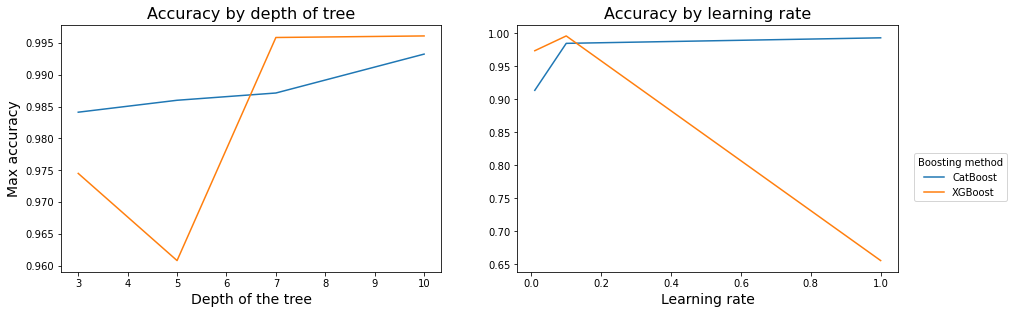

In [19]:
# Plot hyperparameter tuning process
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
# Plot hyperparameter tuning process of tree depth
cb_results.groupby('param_depth')['mean_test_score'].max().plot(label='CatBoost')
xgb_results.groupby('param_max_depth')['mean_test_score'].max().plot(label='XGBoost')
plt.ylabel('Max accuracy', fontsize=14)
plt.xlabel('Depth of the tree', fontsize=14)
plt.title('Accuracy by depth of tree', fontsize=16)

plt.subplot(2,2,2)
# plot hyperparameter tuning process of learning rate
cb_results.groupby('param_learning_rate')['mean_test_score'].max().plot(label='CatBoost')
xgb_results.groupby('param_learning_rate')['mean_test_score'].max().plot(label='XGBoost')
plt.legend(title='Boosting method', bbox_to_anchor=(1.3, 0.5))

plt.xlabel('Learning rate', fontsize=14)
plt.title('Accuracy by learning rate', fontsize=16)

plt.show()

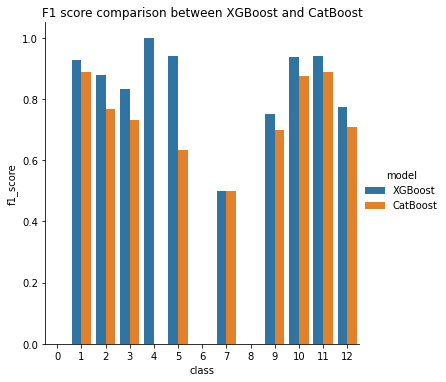

In [36]:
# Train XGBoost model
xgb = XGBClassifier().set_params(**xgb_random.best_params_)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
# Get feature importances and sort
importances_xgb = xgb.feature_importances_
sorted_idx_xgb = importances_xgb.argsort()[::-1]
# Compute precision, recall, and F1-score for XGBoost
precision_xgb, recall_xgb, f1_score_xgb, support_xgb = precision_recall_fscore_support(y_test, y_pred_xgb)
xgb_df = pd.DataFrame({'precision': precision_xgb,'recall': recall_xgb,'f1_score': f1_score_xgb,'support': support})
xgb_df.index.name = 'class'
xgb_df = xgb_df.reset_index()
xgb_df['model'] = 'XGBoost'

# Train CatBoost model
cb = CatBoostClassifier(verbose=False).set_params(**cb_grid.best_params_)
cb.fit(X_train, y_train)
y_pred_cb = cb.predict(X_test)
# Get feature importances and sort
importances_cb = cb.get_feature_importance()
sorted_idx_cb = importances_cb.argsort()[::-1]
# Compute precision, recall, and F1-score for CatBoost
precision_cb, recall_cb, f1_score_cb, support_cb = precision_recall_fscore_support(y_test, y_pred_cb)
cb_df = pd.DataFrame({'precision': precision_cb,'recall': recall_cb,'f1_score': f1_score_cb,'support': support_cb})
cb_df.index.name = 'class'
cb_df = cb_df.reset_index()
cb_df['model'] = 'CatBoost'

# Plot models perpormance
df = pd.concat([xgb_df, cb_df], ignore_index=True)
sns.catplot(x="class", y="f1_score", hue="model", data=df, kind="bar")
plt.title("F1 score comparison between XGBoost and CatBoost")
plt.show()

By the results we see that XGBoost outperforms CatBoost in predicting most of the classes, except for promotion type 7 where both models achieved an equal F1-score. Also, both models struggled to predict promotions from classes 0, 6, and 8.

##### Feature importances

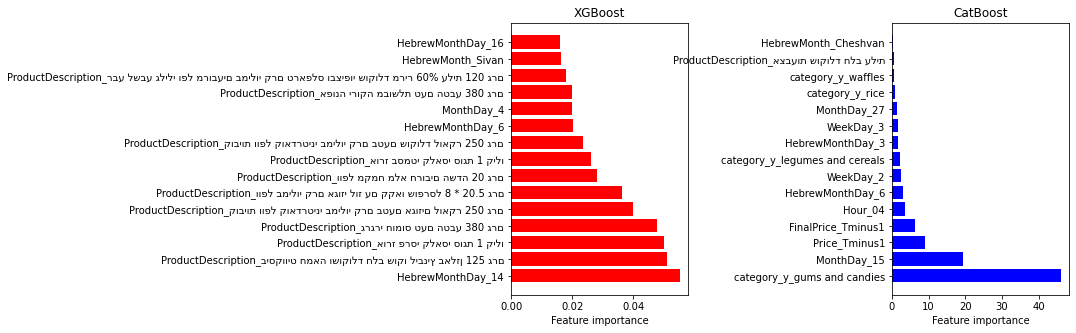

In [37]:
# Plot feature importance for XGBoost
top_n = 15
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.barh(range(top_n), importances_xgb[sorted_idx_xgb][:top_n], color='red')
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(X_train.columns[sorted_idx_xgb][:top_n])
ax1.set_xlabel('Feature importance')
ax1.set_title('XGBoost')

# Plot feature importance for CatBoost
ax2.barh(range(top_n), importances_cb[sorted_idx_cb][:top_n], color='blue')
ax2.set_yticks(range(top_n))
ax2.set_yticklabels(X_train.columns[sorted_idx_cb][:top_n])
ax2.set_xlabel('Feature importance')
ax2.set_title('CatBoost')

plt.subplots_adjust(wspace=1.15)
plt.show()

The 14th day of the Hebrew month and a particular type of biscuit product are the most important features for the XGBoost model, while the CatBoost model places the highest importance on the 'gums and candies' product category and the 15th day of the month. The highest feature importance for a certain product or day can indicate which features have the most impact on the promotion type used by the competitor.

In the case of the XGBoost model, the high feature importance for the 14th day of the Hebrew month and the biscuit product suggests that the competitor is using a specific promotion type for that product or on that day. Similarly, the high feature importance for the "gums and candies" product category and the 15th day of the month for the CatBoost model can suggest a specific promotion type for that product category or day. This information can help supermarkets adjust their pricing strategies to compete more effectively.